In [1]:
import re
import json
import math
from natsort import natsorted
from glob import glob

import pydot
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
from networkx.drawing.nx_pydot import read_dot

from matplotlib import collections  as mc
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.style.use('seaborn-colorblind')


nodePattern = re.compile('^(\d+) ')
edgePattern = re.compile('^(\d+) -- (\d+)')
attrsPattern = re.compile('\[(.+)\]')

def isNode(line):
    return '--' not in line


def processAttrs(line):
    attrs = attrsPattern.findall(line)
    if len(attrs) > 0:
        attrs = attrs[0].split(',')
    attrs = [a.split('=') for a in attrs]
    attrs = [[a[0].strip(), a[1].replace('"','').strip()] for a in attrs]
    for a in attrs:
        try:
            a[1] = int(a[1])
        except ValueError:
            try:
                a[1] = float(a[1])
            except:
                pass
    return attrs


def processEdge(line):
    finding = edgePattern.findall(line)[0]
    source, target = finding[:2]
    source, target = int(source), int(target)
    attrs = processAttrs(line)
    return dict(attrs, source=source, target=target)


def processNode(line):
    nodeId = int(line.split(' ')[0])
    nodeAttrs = processAttrs(line)
    return dict(nodeAttrs, id=nodeId)


def draw(g, pos, edges=True, figsize=[8,8], s=2, lw=0.5):
    xy = np.array(list([pos[k] for k in g.nodes]))
    fig = plt.figure(figsize=figsize)
    ax = fig.subplots()
    
    ## nodes
    ax.scatter(xy[:,0], xy[:,1], s=s, zorder=3)
    
    ## edges
    if edges:
        lines = [[pos[i], pos[j]] for (i,j) in g.edges]
        lc = mc.LineCollection(lines, colors='grey', linewidths=lw)
        ax.add_collection(lc)
    
    ax.autoscale()
    ax.margins(0.1)
#     plt.axis('equal')
    plt.show()

#     plt.figure(figsize=figsize)
#     nx.draw(
#         g, 
#         pos=pos,
#         node_size=10,
#         width=0.5,
#     )




def subtree_sizes(tree, root):
    tree = nx.bfs_tree(g, source=root)
    s = [len(nx.bfs_tree(tree, i).nodes) for i in tree.neighbors(root)]
    total = sum(s)
    return np.array(s)


def fan(nodes, origin=[0,0], radius=1, phaseCenter=0, phaseRange=np.pi, ratio=[1,1]):
    pos = {}
    phases = {}
    ranges = {}
    n = len(nodes)
    cos, sin = np.cos, np.sin
    
    ratioTotal = sum(ratio)
    ratio = [r/ratioTotal for r in ratio]
    
    
    nr = sorted(zip(nodes, ratio), key=lambda x:x[1])
    nr2 = []
    for i in range(len(nr)-1, -1, -1):
        if i%2 == 0:
            nr2.append(nr[i])
        else:
            nr2.insert(0, nr[i])
    nodes, ratio = zip(*nr2)
    
    
    ratioCumSum = [sum(ratio[:i]) for i in range(len(ratio)+1)]
    for i in range(n):
        angle_offset = (ratioCumSum[i]+ratioCumSum[i+1])/2 * phaseRange
        angle_i = phaseCenter - phaseRange/2 + angle_offset
        pos[nodes[i]] = [radius*cos(angle_i), radius*sin(angle_i)]
        phases[nodes[i]] = angle_i
        ranges[nodes[i]] = ratio[i] * phaseRange * 0.95
    return pos, phases, ranges


def radial_layout(g, root=None):
    g0 = g
    g = nx.bfs_tree(g, source=root)
    origin = [0,0]
    pos = {}
    phases = {}
    ranges = {}
    if root is None:
        root = next(iter(g.nodes))
    pos[root] = origin
    phases[root] = 0
    ranges[root] = np.pi*2
#     neighbors = list(g.neighbors(root))
    radius = 0
    roots = [root, ]
    while len(pos) < len(g.nodes):
        radius += 1
        newRoots = []
        for root in roots:
            neighbors = [n for n in g.neighbors(root) if n not in pos]
            subTreeSizes = [len(nx.bfs_tree(g, i).nodes) for i in neighbors]
#             neighborSizes = [len(list(g0.neighbors(i))) for i in neighbors]
            newRoots += neighbors
            if len(neighbors) > 0:
                newPos, newPhases, newRanges = fan(
                    neighbors, 
                    origin, 
                    radius, 
                    phaseCenter=phases[root], 
                    phaseRange=ranges[root], 
                    ratio=subTreeSizes,
                )
                pos.update(newPos)
                phases.update(newPhases)
                ranges.update(newRanges)
        roots = newRoots
    return pos

def normalize(node):
    for prop in node:
        if type(node[prop]) == str:
            node[prop] = node[prop].replace('"', '')
        try:
            node[prop] = int(node[prop])
        except ValueError:
            try:
                node[prop] = float(node[prop])
            except ValueError:
                pass

## generate a graph

In [ ]:
# # ## synthetic data
# fn = './test.dot'
# g = nx.balanced_tree(2, 3)
# nodes = [dict(id=i) for i in g.nodes]
# edges = [dict(source=e[0], target=e[1]) for e in g.edges]
# n = len(nodes)
# i2k = [n['id'] for n in sorted(nodes, key=lambda x:x['id'])]

# print(len(nodes), len(edges), nx.is_tree(g))

In [25]:
fns = natsorted(glob('./data/dot/lastfm-ryn/*.dot'))
max_level = len(fns)
max_weight = 90

## load deepest level
fn = fns[-1]
g = nx.Graph(read_dot(fn))## multi-graph to graph

for k in g.nodes:
    g.nodes[k]['level'] = max_level
#     g.nodes[k]['level'] = 1
    normalize(g.nodes[k])
for e in g.edges:
    g.edges[e]['weight'] = max_weight * 0.5**(max_level-1)
    normalize(g.edges[e])
    
## modify node and edge attributes
for i, fn in enumerate(fns[-2::-1], 1):
    level = max_level - i
#     level = 1
    gi = nx.Graph(read_dot(fn))## multi-graph to graph
    for k in gi.nodes:
        g.nodes[k]['level'] = level
    for e in gi.edges:
        g.edges[e]['weight'] = max_weight * 0.5**(level-1)
        
fn = fns[-1]

# g = nx.Graph()
# g.add_nodes_from(nodes.items())
# g.add_edges_from(edges)

##graph to list
nodes = {k: g.nodes[k] for k in g.nodes}
edges = [[e[0], e[1], g.edges[e]] for e in g.edges]
n = len(nodes)
i2k = sorted(list(nodes), key=lambda x:int(x))
k2i = {k:i for i,k in enumerate(i2k)}
nodes = [{
    'id': i2k[i],
    'index': i,
    **nodes[i2k[i]]
} for i in range(len(nodes))]
edges = [{
    'source': e[0],
    'target': e[1],
    **e[2]
} for e in edges]


# adj = nx.adjacency_matrix(g)
# adj = adj.toarray().astype(np.float)
# d = adj + (1-adj)*1000
# d *= (1-np.eye(len(nodes)))


## all_pairs_shortest_path
apsp = nx.all_pairs_dijkstra_path_length(g, weight=1)
d = np.zeros([len(nodes),len(nodes)])
for dk in tqdm(apsp):
    k = dk[0]
    d[k2i[k],:] = [dk[1][k] for k in i2k]



In [26]:
# ## real data
# fn = './data/dot/topics-iqbal/Topics_Layer_1.dot'
# # fn = './data/dot/lastfm-ryn/lastfm_155nodes.dot'
# nodes = []
# edges = []
# with open(fn) as f:
#     lines = f.readlines()[:-1]
#     lines[0] = lines[0].split('{')[1].strip()
#     for line in lines:
#         if isNode(line):
#             nodes.append(processNode(line))
#         else:
#             edges.append(processEdge(line))
# n = len(nodes)
# nodes = sorted(nodes, key=lambda x:x['id'])
# i2k = [n['id'] for n in nodes]

# g = nx.Graph()
# g.add_nodes_from([n['id'] for n in nodes])
# g.add_edges_from([(e['source'], e['target']) for e in edges])

# print(len(nodes), len(edges), nx.is_tree(g))

# adj = nx.adjacency_matrix(g)
# adj = adj.toarray().astype(np.float)
# # d = adj + (1-adj)*1000
# # d *= (1-np.eye(len(nodes)))


# ## all_pairs_shortest_path
# apsp = nx.all_pairs_shortest_path_length(g)
# d = np.zeros([len(nodes),len(nodes)])
# for i,di in enumerate(tqdm(sorted(apsp))):
#     nodeId = di[0]
#     lengths = [di[1][k] for k in i2k]
#     d[i,:] = lengths
# #     print(nodeId)


## Initial Layout

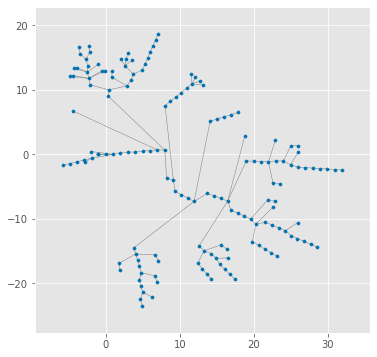

In [27]:
# pos = nx.layout.planar_layout(g, scale=40)
# pos = graphviz_layout(g, prog="dot", root=list(g.nodes)[0])
# pos = graphviz_layout(g, prog='twopi')
# pos = graphviz_layout(g, prog='fdp')

# from scipy.spatial.distance import jensenshannon
# metric = []
# for i in range(len(nodes)):
#     s = subtree_sizes(g, i2k[i])
#     uniform = np.ones(len(s)) / len(s)
#     js = jensenshannon(s, uniform) 
#     metric.append(js)


metric = d.max(axis=1)
iBest = np.argmin(metric)
# iBest = np.argmax(metric)
pos = radial_layout(g, list(g.nodes)[iBest])

draw(g, pos, s=10, figsize=[6,6])


In [ ]:
# from itertools import groupby
# xy = [v for v in pos.values()]
# gb = groupby(xy, key=lambda x:x[1])
# gb = [(key, sorted(list(group))) for key, group in gb]
# left 
# # [(key, list(group)) for key, group in groupby(y, key=la)]

In [ ]:
# xy = np.array( [ pos[i2k[i]]for i in range(len(nodes)) ] )
# theta = (xy[:,0] - xy[:,0].min()) / (xy[:,0].max() - xy[:,0].min()) * np.pi*1
# r = (xy[:,1] - xy[:,1].min())
# # r = -(xy[:,1] - xy[:,1].max())

# xy2 = np.c_[r*np.cos(theta), r*np.sin(theta)]
# pos2 = {i2k[i]:xy2[i] for i in range(len(nodes))}
# draw(g, pos2)

# # pos = pos2

In [ ]:
# from umap import UMAP

# n_neighbors = 15

# umap = UMAP(
#     n_components=2,
#     n_neighbors=n_neighbors, 
#     min_dist=0.3,
#     metric='precomputed',
# #     n_epochs=500,
# #     negative_sample_rate=150,
# #     learning_rate=0.0001,
# #     init=np.array(list(pos.values()))
# )
# xy = umap.fit_transform(d)
# pos2 = {i2k[i]:xy[i,:2] for i in range(len(nodes))}


In [ ]:
# draw(g, pos2)

## to json

In [ ]:
# pos = pos2

In [28]:
perplexities = [len(list(nx.neighbors(g, i))) for i in sorted(g.nodes)]

##store the position & perplexity
for i,node in enumerate(nodes):
    node['x'] = pos[i2k[i]][0]
    node['y'] = pos[i2k[i]][1]
    node['perplexity'] = perplexities[i]
    
## 
for e in edges:
    e['type'] = 'real'
#     e['weight'] = 1


virtual_edges = []
for i in range(n):
    for j in range(i+1, n):
        if d[i,j] == 0:
            print(f'[warning] d[{i},{j}] = 0')
        else:
            weight = d[i,j]
        e = {
            'source': i2k[i],
            'target': i2k[j],
            'weight': weight,
            'type': 'virtual',
        }
        virtual_edges.append(e)
        
        
        
fn_out = fn.split('/')[-1].replace('dot', 'json')
print(fn_out)
with open(fn_out, 'w') as f:
    json.dump(dict(edges=edges, virtual_edges=virtual_edges, nodes=nodes), f, indent=2)


lastfm_155nodes.json
